C:\Users\User\AppData\Local\Temp\ipykernel_12672\2947234506.py:21: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



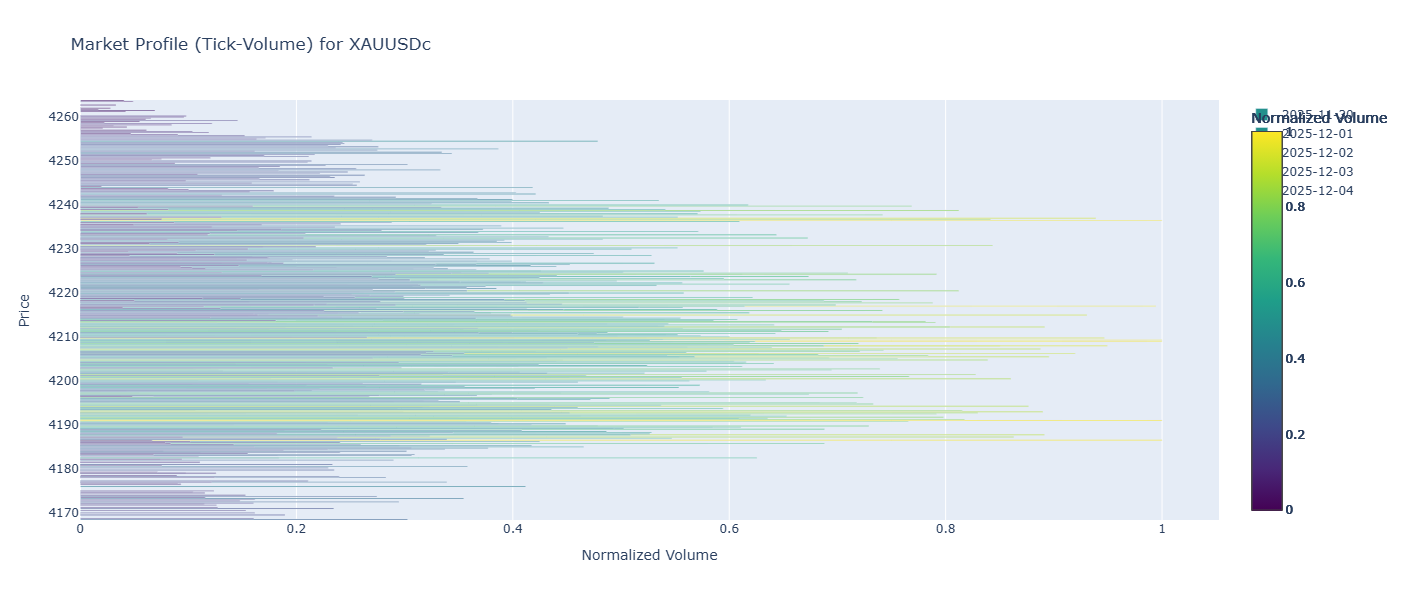

True

In [3]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    raise RuntimeError("Failed to initialize MT5")

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M1  # 1-minute bars as a base
cluster_size = 0.25  # 0.25 price unit precision

# -------------------------------
# 2. Fetch historical ticks or bars
# -------------------------------
# Let's fetch last 5 days of 1-minute data
utc_to = datetime.utcnow()
utc_from = utc_to - timedelta(days=5)

bars = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)
if bars is None or len(bars) == 0:
    raise RuntimeError("No bars fetched")

df = pd.DataFrame(bars)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------------
# 3. Create tick-volume based market profile
# -------------------------------
# Using volume as the "weight" per price level
# First, create price clusters
df['price_cluster'] = (df['close'] / cluster_size).round() * cluster_size

# Group by date and price cluster
df['date'] = df.index.date
profile = df.groupby(['date', 'price_cluster'])['tick_volume'].sum().unstack(fill_value=0)

# Normalize per day for heatmap intensity
profile_norm = profile.div(profile.max(axis=1), axis=0)

# -------------------------------
# 4. Plot Market Profile
# -------------------------------
fig = go.Figure()

for day in profile_norm.index:
    fig.add_trace(go.Bar(
        y=profile_norm.columns, 
        x=profile_norm.loc[day].values,
        name=str(day),
        orientation='h',
        marker=dict(
            color=profile_norm.loc[day].values,
            colorscale='Viridis',
            colorbar=dict(title='Normalized Volume')
        ),
        hovertemplate='Price: %{y}<br>Volume: %{x}<extra></extra>'
    ))

fig.update_layout(
    barmode='overlay',
    title=f'Market Profile (Tick-Volume) for {symbol}',
    xaxis_title='Normalized Volume',
    yaxis_title='Price',
    height=600,
    width=1000
)

fig.show()

# -------------------------------
# 5. Shutdown MT5
# -------------------------------
mt5.shutdown()


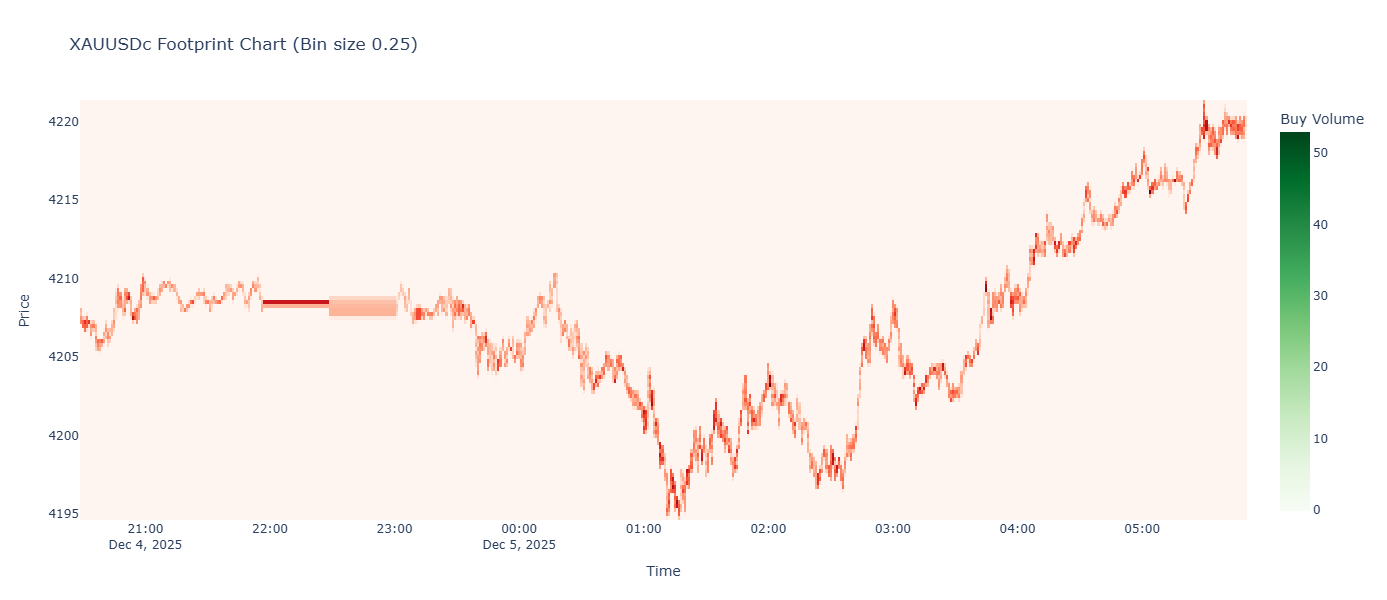

In [8]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    raise RuntimeError("MT5 initialization failed")

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M1  # 1-minute bars
num_bars = 500                # number of bars to fetch
bin_size = 0.25               # price bin size

# -------------------------------
# 2. Fetch data from MT5
# -------------------------------
utc_from = datetime.now() - timedelta(days=0)
rates = mt5.copy_rates_from(symbol, timeframe, utc_from, num_bars)
mt5.shutdown()

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# -------------------------------
# 3. Prepare bins for footprint
# -------------------------------
price_min = np.floor(df['low'].min() / bin_size) * bin_size
price_max = np.ceil(df['high'].max() / bin_size) * bin_size
bins = np.arange(price_min, price_max + bin_size, bin_size)
bin_labels = bins[:-1]  # histogram returns len(bins)-1

# Initialize footprint DataFrames
footprint_buy = pd.DataFrame(0, index=df['time'], columns=bin_labels)
footprint_sell = pd.DataFrame(0, index=df['time'], columns=bin_labels)

# -------------------------------
# 4. Aggregate tick volumes into bins
# -------------------------------
for i, row in df.iterrows():
    ticks = int(row['tick_volume'])
    
    # Simulate tick-level prices within bar range
    tick_prices = np.random.uniform(row['low'], row['high'], ticks)
    
    # Simulate bid/ask split (50/50 or random)
    tick_side = np.random.choice(['buy', 'sell'], size=ticks, p=[0.5, 0.5])
    
    # Buy histogram
    counts_buy, _ = np.histogram(tick_prices[tick_side == 'buy'], bins=bins)
    # Sell histogram
    counts_sell, _ = np.histogram(tick_prices[tick_side == 'sell'], bins=bins)
    
    # Assign to DataFrames
    footprint_buy.iloc[i, :] = counts_buy
    footprint_sell.iloc[i, :] = counts_sell

# -------------------------------
# 5. Plot footprint heatmap
# -------------------------------
fig = go.Figure()

# Buy volume heatmap (green)
fig.add_trace(go.Heatmap(
    z=footprint_buy.values.T,
    x=footprint_buy.index,
    y=footprint_buy.columns,
    colorscale='Greens',
    colorbar=dict(title='Buy Volume'),
    name='Buy Volume'
))

# Sell volume heatmap (red)
fig.add_trace(go.Heatmap(
    z=footprint_sell.values.T,
    x=footprint_sell.index,
    y=footprint_sell.columns,
    colorscale='Reds',
    colorbar=dict(title='Sell Volume'),
    name='Sell Volume',
    showscale=False  # hide second colorbar to avoid clutter
))

fig.update_layout(
    title=f'{symbol} Footprint Chart (Bin size {bin_size})',
    xaxis_title='Time',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    height=600,
    width=1200
)

fig.show()


In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    raise RuntimeError("MT5 initialization failed")

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M1  # 1-minute bars
num_bars = 500                # number of bars to fetch
bin_size = 0.25               # price bin size

# -------------------------------
# 2. Fetch data from MT5
# -------------------------------
utc_from = datetime.now() - timedelta(days=5)
rates = mt5.copy_rates_from(symbol, timeframe, utc_from, num_bars)
mt5.shutdown()

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# -------------------------------
# 3. Prepare bins for footprint
# -------------------------------
price_min = np.floor(df['low'].min() / bin_size) * bin_size
price_max = np.ceil(df['high'].max() / bin_size) * bin_size
bins = np.arange(price_min, price_max + bin_size, bin_size)
bin_labels = bins[:-1]  # histogram returns len(bins)-1

# Initialize footprint DataFrames
footprint = pd.DataFrame(0, index=df['time'], columns=bin_labels)

# -------------------------------
# 4. Aggregate tick volumes into bins (buy/sell split)
# -------------------------------
for i, row in df.iterrows():
    ticks = int(row['tick_volume'])
    tick_prices = np.random.uniform(row['low'], row['high'], ticks)
    
    # Assign buy (+) or sell (-)
    tick_side = np.random.choice([1, -1], size=ticks, p=[0.5, 0.5])
    tick_values = tick_side  # +1 for buy, -1 for sell

    # Bin the tick prices with signed volumes
    for j, price in enumerate(tick_prices):
        bin_index = np.searchsorted(bin_labels, price, side='right') - 1
        if 0 <= bin_index < len(bin_labels):
            footprint.iloc[i, bin_index] += tick_values[j]

# -------------------------------
# 5. Plot footprint heatmap with OHLC candles
# -------------------------------
fig = go.Figure()

# Footprint heatmap: red <0, green >0
colorscale = [[0.0, 'red'], [0.5, 'white'], [1.0, 'green']]
fig.add_trace(go.Heatmap(
    z=footprint.values.T,
    x=footprint.index,
    y=footprint.columns,
    colorscale=colorscale,
    colorbar=dict(title='Signed Tick Volume'),
    zmid=0
))

# Overlay OHLC candles
fig.add_trace(go.Candlestick(
    x=df['time'],
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='black',
    decreasing_line_color='black',
    opacity=0.8,
    name='OHLC'
))

fig.update_layout(
    title=f'{symbol} Footprint Chart with OHLC (Bin size {bin_size})',
    xaxis_title='Time',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    height=700,
    width=1200
)

fig.show()
